In [8]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
import h5py


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"GPU Detected: {gpu.device_type} - {gpu.name}")
else:
    print("No GPU detected")

No GPU detected


## Data acquisition

In [9]:
# Read data form csv
df = pd.read_csv("./FERPlus-master/fer2013new.csv")
df

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
35882,PrivateTest,fer0035797.png,8,0,0,2,0,0,0,0,0,0
35883,PrivateTest,NaN,0,0,0,0,0,0,0,0,0,10
35884,PrivateTest,fer0035799.png,0,0,0,0,7,1,0,2,0,0
35885,PrivateTest,fer0035800.png,0,10,0,0,0,0,0,0,0,0


In [10]:
# Display its general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Usage       35887 non-null  object
 1   Image name  35714 non-null  object
 2   neutral     35887 non-null  int64 
 3   happiness   35887 non-null  int64 
 4   surprise    35887 non-null  int64 
 5   sadness     35887 non-null  int64 
 6   anger       35887 non-null  int64 
 7   disgust     35887 non-null  int64 
 8   fear        35887 non-null  int64 
 9   contempt    35887 non-null  int64 
 10  unknown     35887 non-null  int64 
 11  NF          35887 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 3.3+ MB


# Preprocessing

In [11]:
# Check for any missing data particularly in 'Image name' column
missing_data = df.isnull().sum()
missing_data

Usage           0
Image name    173
neutral         0
happiness       0
surprise        0
sadness         0
anger           0
disgust         0
fear            0
contempt        0
unknown         0
NF              0
dtype: int64

In [19]:
# Remove entries with missing 'Image name'
clean_df = df.dropna(subset=['Image name'])

# Confirm the removal
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35714 entries, 0 to 35886
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Usage       35714 non-null  object
 1   Image name  35714 non-null  object
 2   neutral     35714 non-null  int64 
 3   happiness   35714 non-null  int64 
 4   surprise    35714 non-null  int64 
 5   sadness     35714 non-null  int64 
 6   anger       35714 non-null  int64 
 7   disgust     35714 non-null  int64 
 8   fear        35714 non-null  int64 
 9   contempt    35714 non-null  int64 
 10  unknown     35714 non-null  int64 
 11  NF          35714 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 3.5+ MB


In [20]:
# Extracting the emotion columns
emotion_columns = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 
                   'disgust', 'fear', 'contempt', 'unknown', 'NF']

# Finding the index of the maximum value in the emotion columns
clean_df['predominant_emotion_index'] = clean_df[emotion_columns].idxmax(axis=1).apply(emotion_columns.index)

# Drop the original emotion columns
emo_idx_df = clean_df.drop(columns=emotion_columns)

# Show the updated dataset with the new 'predominant_emotion_index' column
emo_idx_df

C:\Users\julio\AppData\Local\Temp\ipykernel_16672\285943505.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['predominant_emotion_index'] = clean_df[emotion_columns].idxmax(axis=1).apply(emotion_columns.index)


,Usage,Image name,predominant_emotion_index
0,Training,fer0000000.png,0
1,Training,fer0000001.png,0
2,Training,fer0000002.png,0
3,Training,fer0000003.png,0
4,Training,fer0000004.png,0
...,...,...,...
35881,PrivateTest,fer0035796.png,0
35882,PrivateTest,fer0035797.png,0
35884,PrivateTest,fer0035799.png,4
35885,PrivateTest,fer0035800.png,1


In [22]:
# Count of row types
print(emo_idx_df['Usage'].value_counts())

Usage
Training       28561
PublicTest      3579
PrivateTest     3574
Name: count, dtype: int64


In [23]:
emotion_labels = {
    0: "neutral",
    1: "happiness",
    2: "surprise",
    3: "sadness",
    4: "anger",
    5: "disgust",
    6: "fear",
    7: "contempt",
    8: "unknown",
    9: "not a face"
}

unique_indices, counts = np.unique(emo_idx_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

       Emotion  Count
0      neutral  12906
1    happiness   9355
2     surprise   4462
3      sadness   4371
4        anger   3111
5      disgust    248
6         fear    819
7     contempt    216
8      unknown    222
9   not a face      4
10       Total  35714


In [27]:
emo_idx_df = emo_idx_df[emo_idx_df['predominant_emotion_index'] != 9]
emo_idx_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35710 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Usage                      35710 non-null  object
 1   Image name                 35710 non-null  object
 2   predominant_emotion_index  35710 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


     Emotion  Count
0    neutral  12906
1  happiness   9355
2   surprise   4462
3    sadness   4371
4      anger   3111
5    disgust    248
6       fear    819
7   contempt    216
8    unknown    222
9      Total  35710


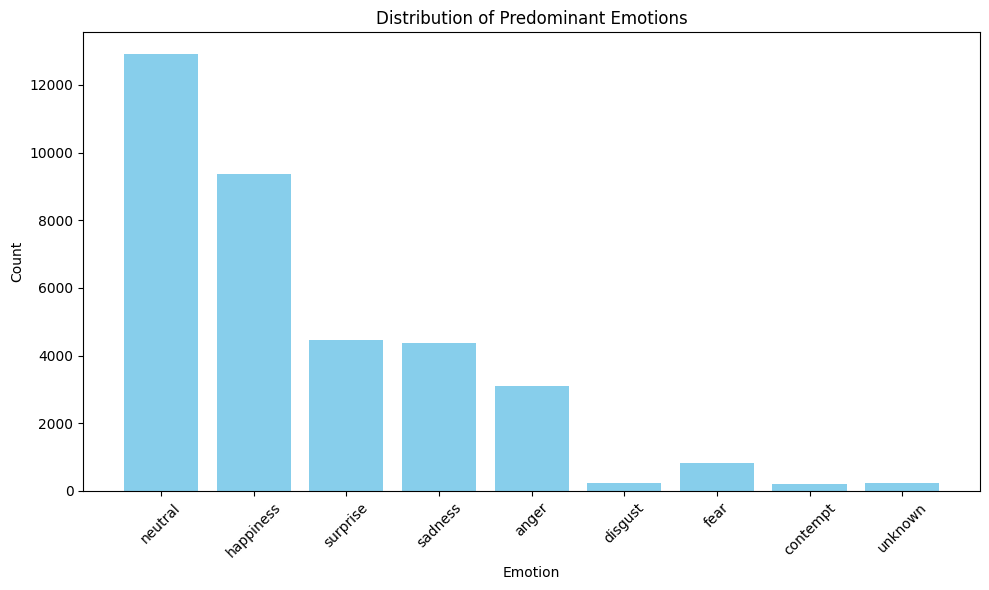

In [38]:
unique_indices, counts = np.unique(emo_idx_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

plt.figure(figsize=(10, 6))
plt.bar(emotion_counts['Emotion'][:-1], emotion_counts['Count'][:-1], color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Predominant Emotions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Splitting data

In [37]:
# Creating separate DataFrame variables for each 'Usage' type
train_df = emo_idx_df[emo_idx_df['Usage'] == 'Training']
valid_df = emo_idx_df[emo_idx_df['Usage'] == 'PublicTest']
test_df = emo_idx_df[emo_idx_df['Usage'] == 'PrivateTest']
train_df.shape, valid_df.shape, test_df.shape

((28559, 3), (3578, 3), (3573, 3))

In [42]:
unique_indices, counts = np.unique(train_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

     Emotion  Count
0    neutral  10309
1  happiness   7528
2   surprise   3562
3    sadness   3515
4      anger   2467
5    disgust    191
6       fear    652
7   contempt    165
8    unknown    170
9      Total  28559


In [43]:
unique_indices, counts = np.unique(valid_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

     Emotion  Count
0    neutral   1335
1  happiness    899
2   surprise    456
3    sadness    412
4      anger    319
5    disgust     34
6       fear     74
7   contempt     24
8    unknown     25
9      Total   3578


In [44]:
unique_indices, counts = np.unique(test_df['predominant_emotion_index'], return_counts=True)

# Create a DataFrame
emotion_counts = pd.DataFrame({
    'Emotion': [emotion_labels[index] for index in unique_indices],
    'Count': counts
})

# Add a total row
total = emotion_counts['Count'].sum()
total_row = pd.DataFrame({'Emotion': ['Total'], 'Count': [total]})
emotion_counts = pd.concat([emotion_counts, total_row], ignore_index=True)

# Display the DataFrame
print(emotion_counts)

     Emotion  Count
0    neutral   1262
1  happiness    928
2   surprise    444
3    sadness    444
4      anger    325
5    disgust     23
6       fear     93
7   contempt     27
8    unknown     27
9      Total   3573


## Image Loading and Normalization

In [64]:
# Load and normalize images
def load_images(data, base_path):
    images = []
    labels = []
    paths = []
    
    # Mapping from Usage to directory names
    directory_map = {
        "Training": "FER2013Train",
        "PublicTest": "FER2013Valid",
        "PrivateTest": "FER2013Test"
    }
    
    for idx, row in data.iterrows():
        directory = directory_map.get(row['Usage'], None)
        if directory:
            image_path = os.path.join(base_path, directory, row['Image name'])
            
            if os.path.exists(image_path):
                # Load the image
                image = Image.open(image_path).convert('L')  # Convert to grayscale
                image_array = np.array(image) / 255.0  # Normalize to 0-1
                
                # Append data
                images.append(image_array)
                labels.append(row['predominant_emotion_index'])  # Select emotion intensity columns
                paths.append(image_path)
    
    return np.array(images), np.array(labels), paths

# Base path for images
base_image_path = 'FERPLUS-master/data'

# Load images and their labels
train_images, train_labels, train_image_paths = load_images(train_df, base_image_path)
valid_images, valid_labels, valid_image_paths = load_images(valid_df, base_image_path)
test_images, test_labels, test_image_paths = load_images(test_df, base_image_path)

# Check shapes and an example path
print("Train images shape:", train_images.shape, train_images.dtype)
print("Train labels shape:", train_labels.shape, train_labels.dtype)

print("Valid images shape:", valid_images.shape, valid_images.dtype)
print("Valid labels shape:", valid_labels.shape, valid_labels.dtype)

print("Tests images shape:", test_images.shape, test_images.dtype)
print("Tests labels shape:", test_labels.shape, test_labels.dtype)


Train images shape: (28559, 48, 48) float64
Train labels shape: (28559,) int32
Valid images shape: (3578, 48, 48) float64
Valid labels shape: (3578,) int32
Tests images shape: (3573, 48, 48) float64
Tests labels shape: (3573,) int32


# Basic CNN

In [52]:
# Create a basic CNN model
basic_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),  # first conv layer
    MaxPooling2D((2, 2)),  # first pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # second conv layer
    MaxPooling2D((2, 2)),  # second pooling layer
    Conv2D(128, (3, 3), activation='relu'),  # third conv layer
    MaxPooling2D((2, 2)),  # third pooling layer
    Flatten(),  # flatten the output for the dense layer
    Dense(128, activation='relu'),  # fully connected layer
    Dropout(0.5),  # dropout for regularization
    Dense(10, activation='softmax')  # output layer with 10 units for each emotion
])

basic_model.summary()  # This will print the summary of the model architecture

d:\Julio\Uc3m\TFG\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,234 (1.36 MB)

 Trainable params: 356,234 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Compile the model
basic_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Reshape images to add channel dimension for CNN

In [54]:
# Reshape or modify the data to add a channel dimension for CNNs, expect an input shape like (batch, height, width, channels)
# Channel dimension is 1 for grayscale images
train_images = train_images.reshape((-1, 48, 48, 1))
valid_images = valid_images.reshape((-1, 48, 48, 1))
test_images = test_images.reshape((-1, 48, 48, 1))

In [56]:
print("Train images shape:", train_images.shape, train_images.dtype)
print("Train labels shape:", train_labels.shape, train_labels.dtype)

print("Valid images shape:", valid_images.shape, valid_images.dtype)
print("Valid labels shape:", valid_labels.shape, valid_labels.dtype)

print("Tests images shape:", test_images.shape, test_images.dtype)
print("Tests labels shape:", test_labels.shape, test_labels.dtype)

Train images shape: (28559, 48, 48, 1) float64
Train labels shape: (28559,) int32
Valid images shape: (3578, 48, 48, 1) float64
Valid labels shape: (3578,) int32
Tests images shape: (3573, 48, 48, 1) float64
Tests labels shape: (3573,) int32


## Fit model

In [57]:
# Fit the model
basic_model_history = basic_model.fit(
    train_images, train_labels,
    epochs=30,
    batch_size=64,
    validation_data=(valid_images, valid_labels)
)

Epoch 1/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.3587 - loss: 1.6834 - val_accuracy: 0.5439 - val_loss: 1.3473
Epoch 2/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5633 - loss: 1.3017 - val_accuracy: 0.6230 - val_loss: 1.0851
Epoch 3/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6316 - loss: 1.0808 - val_accuracy: 0.6722 - val_loss: 0.9560
Epoch 4/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6649 - loss: 0.9861 - val_accuracy: 0.6878 - val_loss: 0.9015
Epoch 5/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6928 - loss: 0.9011 - val_accuracy: 0.7018 - val_loss: 0.8630
Epoch 6/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7066 - loss: 0.8468 - val_accuracy: 0.6970 - val_loss: 0.8624
Epoch 7/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7264 - loss: 0.7931 - val_accuracy: 0.7230 - val_loss: 0.8153
Epoch 8/30
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.7378 - loss: 0.7537 - val_ac

## Evaluate

In [58]:
# Evaluate the model
test_loss, test_acc = basic_model.evaluate(test_images, test_labels)
print("Basic Model Test Accuracy:", test_acc)

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7162 - loss: 1.3877
Test Accuracy: 0.7201231718063354


## Plot 

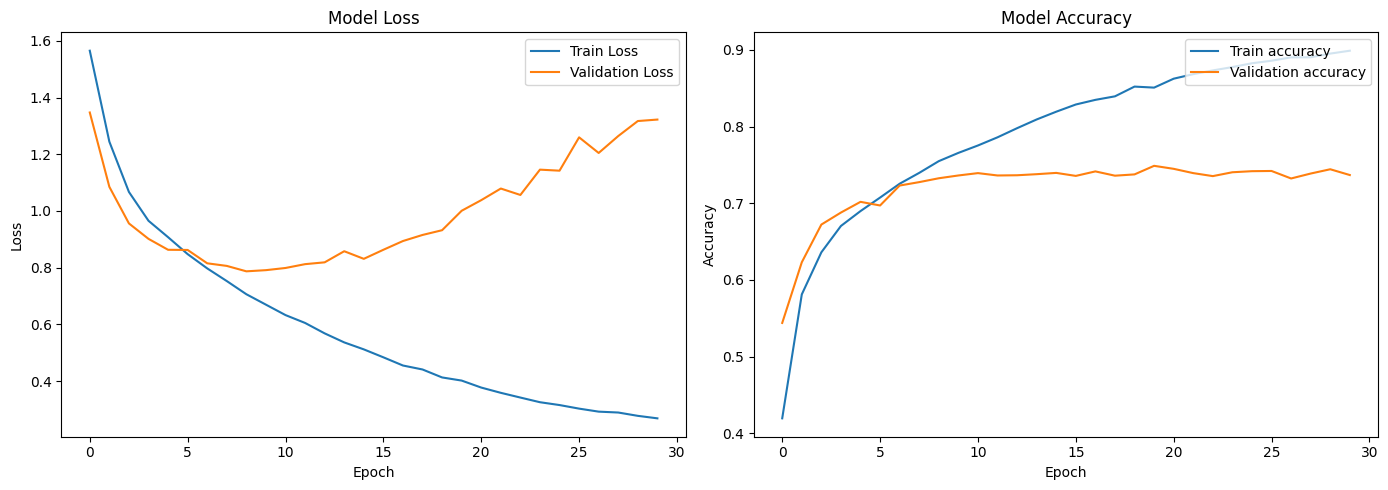

In [59]:
# Plot the history
# Assuming 'history' is the output from your model.fit()
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(basic_model_history.history['loss'], label='Train Loss')
plt.plot(basic_model_history.history['val_loss'], label='Validation Loss')
plt.title('Basic Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation mean squared error
plt.subplot(1, 2, 2)
plt.plot(basic_model_history.history['accuracy'], label='Train accuracy')
plt.plot(basic_model_history.history['val_accuracy'], label='Validation accuracy')
plt.title('Basic Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [60]:
# Get the prediction reusults
predictions = basic_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
test_labels, predicted_labels

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(array([7, 3, 0, ..., 4, 1, 3]), array([0, 0, 2, ..., 0, 1, 3], dtype=int64))

In [61]:
accuracy = accuracy_score(test_labels, predicted_labels)
print("Basic Model Accuracy:", accuracy)

Accuracy: 0.720123145815841


## Confusion Matrix

Confusion Matrix:
 [[1004   70   32  118   27    3    5    3    0]
 [  81  772   31   29   13    0    2    0    0]
 [  45   21  352    9   10    0    7    0    0]
 [ 158   33   10  229   11    2    1    0    0]
 [  68   29   26   23  176    0    3    0    0]
 [   1    2    2    4    5    9    0    0    0]
 [  14    7   30   11    4    0   27    0    0]
 [  13    2    3    5    0    1    0    3    0]
 [  12    3    2    7    2    0    0    0    1]]


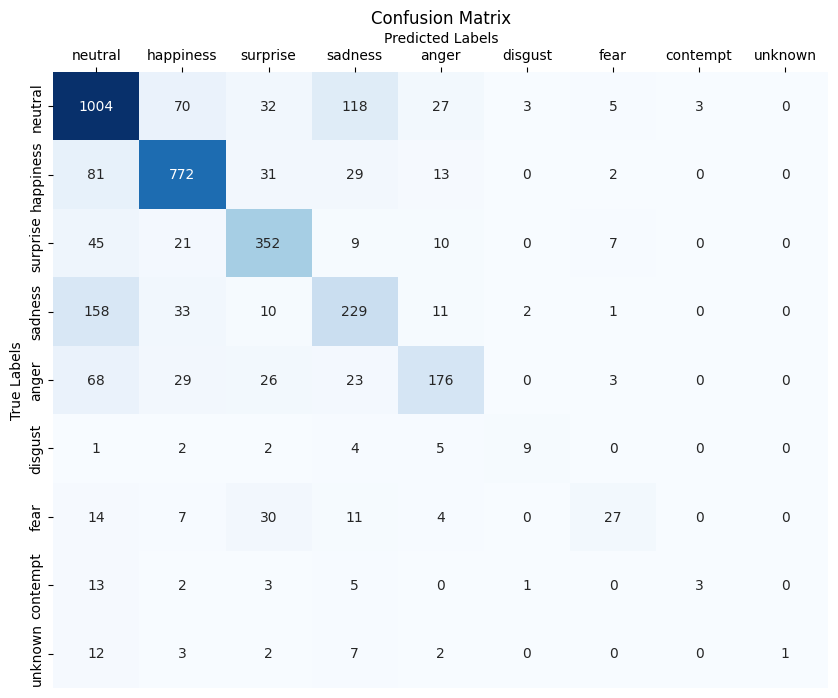

In [62]:
# Get the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("Basic Model Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values(), cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Basic Model Confusion Matrix')

# Move the X-axis to the top of the plot
ax.xaxis.tick_top()  # X-axis on top
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top

plt.show()

# Advanced CNN (VGG-like, ResNet)

## Preprocessing

In [63]:
print("Train images shape:", train_images.shape, train_images.dtype)
print("Valid images shape:", valid_images.shape, valid_images.dtype)
print("Tests images shape:", test_images.shape, test_images.dtype)

print("Train labels shape:", train_labels.shape, train_labels.dtype)
print("Valid labels shape:", valid_labels.shape, valid_labels.dtype)
print("Tests labels shape:", test_labels.shape, test_labels.dtype)

Train images shape: (28559, 48, 48, 1) float64
Valid images shape: (3578, 48, 48, 1) float64
Tests images shape: (3573, 48, 48, 1) float64
Train labels shape: (28559,) int32
Valid labels shape: (3578,) int32
Tests labels shape: (3573,) int32


## Resize images and save

In [67]:
# Function to save images resized and normalized, and label values to HDF5 
def save_images_to_hdf5(train_df, valid_df, test_df, base_path, hdf5_file):
    # Create a new HDF5 file or open an existing file
    with h5py.File(hdf5_file, 'w') as file:
        # Create datasets to store images, labels, and paths
        train_images = file.create_dataset('train_images', (train_df.shape[0], 224, 224, 3), dtype='float64')
        valid_images = file.create_dataset('valid_images', (valid_df.shape[0], 224, 224, 3), dtype='float64')
        test_images = file.create_dataset('test_images', (test_df.shape[0], 224, 224, 3), dtype='float64')

        train_labels = file.create_dataset('train_images_labels', (train_df.shape[0]), dtype='int32')
        valid_labels = file.create_dataset('valid_images_labels', (valid_df.shape[0]), dtype='int32')
        test_labels = file.create_dataset('test_images_labels', (test_df.shape[0]), dtype='int32')

        directory_map = {
            "Training": "FER2013Train",
            "PublicTest": "FER2013Valid",
            "PrivateTest": "FER2013Test"
        }

        # Counters for each dataset to track insertion positions
        train_idx, valid_idx, test_idx = 0, 0, 0
        
        # Store images in corresponding datasets
        for idx, row in train_df.iterrows():
            directory = directory_map.get(row['Usage'], None)
            if directory:
                image_path = os.path.join(base_path, directory, row['Image name'])
                label = row['predominant_emotion_index']

                # Load and process the image
                image = Image.open(image_path).convert('L')
                image = image.resize((224, 224))
                image_array = np.array(image) / 255.0
                image_array = np.stack((image_array,)*3, axis=-1)

                train_images[train_idx] = image_array
                train_labels[train_idx] = label
                train_idx += 1
        
        for idx, row in valid_df.iterrows():
            directory = directory_map.get(row['Usage'], None)
            if directory:
                image_path = os.path.join(base_path, directory, row['Image name'])
                label = row['predominant_emotion_index']

                # Load and process the image
                image = Image.open(image_path).convert('L')
                image = image.resize((224, 224))
                image_array = np.array(image) / 255.0
                image_array = np.stack((image_array,)*3, axis=-1)

                valid_images[valid_idx] = image_array
                valid_labels[valid_idx] = label
                valid_idx += 1

        for idx, row in test_df.iterrows():
            directory = directory_map.get(row['Usage'], None)
            if directory:
                image_path = os.path.join(base_path, directory, row['Image name'])
                label = row['predominant_emotion_index']

                # Load and process the image
                image = Image.open(image_path).convert('L')
                image = image.resize((224, 224))
                image_array = np.array(image) / 255.0
                image_array = np.stack((image_array,)*3, axis=-1)

                test_images[test_idx] = image_array
                test_labels[test_idx] = label
                test_idx += 1

# Base path for images
base_image_path = 'FERPLUS-master/data'
hdf5_file = 'processed_images.hdf5'

# Assuming 'clean_df' is your DataFrame containing the image metadata
save_images_to_hdf5(train_df, valid_df, test_df, base_image_path, hdf5_file)

In [68]:
# Function to inspect the contents of an HDF5 file
def inspect_hdf5_file(filepath):
    # Open the HDF5 file
    with h5py.File(filepath, 'r') as file:
        print("Datasets contained within the file:")
        for dataset_name in file:
            # Access the dataset
            dataset = file[dataset_name]
            # Print details about the dataset
            print(f"Dataset Info: {dataset_name}, {dataset.shape}, {dataset.dtype}")

# Call the function to inspect the HDF5 file
inspect_hdf5_file(hdf5_file)

Datasets contained within the file:
Dataset Info: test_images, (3573, 224, 224, 3), float64
Dataset Info: test_images_labels, (3573,), int32
Dataset Info: train_images, (28559, 224, 224, 3), float64
Dataset Info: train_images_labels, (28559,), int32
Dataset Info: valid_images, (3578, 224, 224, 3), float64
Dataset Info: valid_images_labels, (3578,), int32


## Image generator function

In [69]:
# Define a generator function to load images from the HDF5 file
def hdf5_image_generator(filepath, dataset_name, batch_size):
    while True:  # Loop indefinitely
        with h5py.File(filepath, 'r') as file:
            images = file[dataset_name]
            labels = file[dataset_name + '_labels']  # Adjust if your labels are stored differently
            num_samples = images.shape[0]

            for start in range(0, num_samples, batch_size):
                end = min(start + batch_size, num_samples)
                yield images[start:end], labels[start:end]

batch_size = 32

# Create generators for training and validation
train_generator = hdf5_image_generator(hdf5_file, 'train_images', batch_size)
valid_generator = hdf5_image_generator(hdf5_file, 'valid_images', batch_size)
test_generator = hdf5_image_generator(hdf5_file, 'test_images', batch_size)

# Get the lengths of the datasets
def get_dataset_lengths(filepath):
    with h5py.File(filepath, 'r') as file:
        lengths = {}
        for dataset_name in file:
            dataset = file[dataset_name]
            lengths[dataset_name] = len(dataset)
    return lengths

dataset_lengths = get_dataset_lengths(hdf5_file)
train_steps_per_epoch = dataset_lengths['train_images'] // batch_size
valid_steps = dataset_lengths['valid_images'] // batch_size
test_steps = dataset_lengths['test_images'] // batch_size

## Early stopping callback

In [70]:
# Implement EarlyStopping callback function
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor the validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Log when training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

## VGG16 Model

In [71]:
# Load the base model with pre-trained weights on ImageNet and without the top layer
vgg16_base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Flatten the output layer to 1 dimension
x = Flatten()(vgg16_base_model.output)

# Add a fully connected layer with 256 hidden units and ReLU activation
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Add a final softmax layer for classification
output = Dense(10, activation='softmax')(x)

# Configure and compile the model
vgg16_model = Model(inputs=vgg16_base_model.input, outputs=output)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Fit model

In [ ]:
# Fit the model using the generator
vgg16_model_history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    #callbacks=[early_stopping]
)

### Evaluate

In [ ]:
# Perform evaluation
test_loss, test_acc = vgg16_model.evaluate(test_generator, steps=test_steps)
print("VGG16 Model Test Accuracy:", test_acc)

### Plot

In [ ]:
# Plot the history
# Assuming 'history' is the output from your model.fit()
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(vgg16_model_history.history['loss'], label='Train Loss')
plt.plot(vgg16_model_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation mean squared error
plt.subplot(1, 2, 2)
plt.plot(vgg16_model_history.history['accuracy'], label='Train accuracy')
plt.plot(vgg16_model_history.history['val_accuracy'], label='Validation accuracy')
plt.title('VGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
predictions = vgg16_model.predict(test_generator, steps=test_steps)
predicted_labels = np.argmax(predictions, axis=1)
test_labels, predicted_labels

In [ ]:
accuracy = accuracy_score(test_labels, predicted_labels)
print("VGG16 Model Accuracy:", accuracy)

### Confusion Matrix

In [ ]:
# Get the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("VGG16 Model Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values(), cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('VGG16 Model Confusion Matrix')

# Move the X-axis to the top of the plot
ax.xaxis.tick_top()  # X-axis on top
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top

plt.show()

## ResNet50 Model

In [72]:
# Load ResNet50 model, similar adjustments as VGG16
resnet50_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = Flatten()(resnet50_base_model.output)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(10, activation='softmax')(x)

resnet50_model = Model(inputs=resnet50_base_model.input, outputs=output)
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Fit model

In [ ]:
# Fit the model
resnet50_model_history = resnet50_model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,
    batch_size=32,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    #callbacks=[early_stopping]  # Include the early stopping callback
)

### Evaluate

In [ ]:
# Perform evaluation
test_loss, test_acc = resnet50_model.evaluate(test_generator, steps=test_steps)
print("ResNet50 Model Test Accuracy:", test_acc)

### Plot

In [ ]:
# Plot the history
# Assuming 'history' is the output from your model.fit()
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(resnet50_model_history.history['loss'], label='Train Loss')
plt.plot(resnet50_model_history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation mean squared error
plt.subplot(1, 2, 2)
plt.plot(resnet50_model_history.history['accuracy'], label='Train accuracy')
plt.plot(resnet50_model_history.history['val_accuracy'], label='Validation accuracy')
plt.title('ResNet50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
predictions = resnet50_model.predict(test_generator, steps=test_steps)
predicted_labels = np.argmax(predictions, axis=1)
test_labels, predicted_labels

In [ ]:
accuracy = accuracy_score(test_labels, predicted_labels)
print("ResNet50 Model Accuracy:", accuracy)

### Confusion Matrix

In [ ]:
# Get the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("ResNet50 Model Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values(), cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('ResNet50 Model Confusion Matrix')

# Move the X-axis to the top of the plot
ax.xaxis.tick_top()  # X-axis on top
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top

plt.show()

# Transfer Learning (VGGFace, FaceNet)

In [73]:
print("Train images shape:", train_images.shape, train_images.dtype)
print("Valid images shape:", valid_images.shape, valid_images.dtype)
print("Tests images shape:", test_images.shape, test_images.dtype)

print("Train labels shape:", train_labels.shape, train_labels.dtype)
print("Valid labels shape:", valid_labels.shape, valid_labels.dtype)
print("Tests labels shape:", test_labels.shape, test_labels.dtype)

Train images shape: (28559, 48, 48) float64
Valid images shape: (3578, 48, 48) float64
Tests images shape: (3573, 48, 48) float64
Train labels shape: (28559,) int32
Valid labels shape: (3578,) int32
Tests labels shape: (3573,) int32
